In [90]:
import numpy as np
from scipy.optimize import minimize

In [91]:
dt = 0.01                       # timestep
n =10000                        # nr of timesteps
x = np.zeros(n)                 # variables
y = np.zeros(n)
z = np.zeros(n)
dxdt = np.zeros(n)              # first derivative
xdt = np.zeros(n)
ydt = np.zeros(n)
zdt = np.zeros(n)
dydt = np.zeros(n)
dzdt = np.zeros(n)
sigma = 10                      # constants
beta = 2.7
rho = 28
b=3

In [92]:
x[0] = np.random.rand()         # initial positions
y[0] = np.random.rand()
z[0] = np.random.rand()

In [93]:
def generate(x,y,z,dt):
    
    for i in range(n-1):
        
        x[i+1] = x[i] + dt*sigma*(y[i]-x[i]) + b*np.sqrt(dt)*np.random.normal()           # explicit euler step
        y[i+1] = y[i] + dt*((x[i]*(rho-z[i]))-y[i]) + b*np.sqrt(dt)*np.random.normal()
        z[i+1] = z[i] + dt*((x[i]*y[i])-(beta*z[i])) + b*np.sqrt(dt)*np.random.normal()
    
    for i in range(n-1):
    
        
        
        dxdt[i]= (x[i+1]-x[i])/dt
        xdt[i] = sigma*(y[i]-x[i])
        dydt[i] = (y[i+1]-y[i])/dt
        ydt[i] = ((x[i]*(rho-z[i]))-y[i])
        dzdt[i] = (z[i+1]-z[i])/dt
        zdt[i] = ((x[i]*y[i])-(beta*z[i]))
        
    '''for i in range(n-1):
        
        dxdt1 = minimize(fun=(np.sum((dxdt[i]-xdt[i])**2) + 0.5*(np.sum(dxdt[i+1]-dxdt[i]))),x0=dxdt)
        dydt1 = minimize(fun=(np.sum((dydt[i]-ydt[i])**2) + 0.5*(np.sum(dydt[i+1]-dydt[i]))),x0=dydt)
        dzdt1 = minimize(fun=(np.sum((dzdt[i]-zdt[i])**2) + 0.5*(np.sum(dzdt[i+1]-dzdt[i]))),x0=dzdt)'''
        
    

In [94]:
generate(x,y,z,dt)

In [95]:
import matplotlib.pyplot as plt

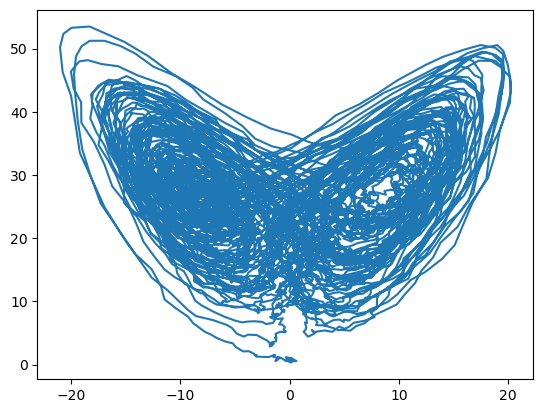

In [96]:
plt.plot(x,z)

In [25]:
theta = np.column_stack((np.ones(n),x,y,z,x*x,y*y,z*z,x*y,x*z,y*z))    # dictionary of functions

In [26]:
ddt = np.column_stack((dxdt,dydt,dzdt))              # first derivative matrix

In [27]:
zeta = np.linalg.lstsq(theta,ddt , rcond=None)[0]    # initial guess

In [28]:
for i in range(10):
    smallinds = np.abs(zeta)<0.01         # thresholding the zeta values
    zeta[smallinds] = 0
    
    for ind in range(3):                  # iterate through state variables
        biginds = ~smallinds[:,ind]       # regress the original problem after thresholding
        zeta[biginds, ind] = np.linalg.lstsq(theta[:, biginds], ddt[:, ind], rcond=None)[0] # new zeta values

In [29]:
zeta

array([[ 0.        ,  0.        ,  0.        ],
       [-9.99984173, 28.00048098,  0.        ],
       [ 9.99996019, -1.00012128,  0.        ],
       [ 0.        ,  0.        , -2.69993786],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99999728],
       [ 0.        , -1.00000879,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])